# **Basic Data Analytics**

## Objectives

* In this notebook, we will do some preliminary statistical analysis, such as a correlation study, as well as various visualizations.

## Inputs

* The input for this is the cleaned data from the last notebook, namely `'game_data_clean.csv'`.

## Outputs

* At the end, we will have various plots displaying the statistical relationship between different features of our dataset.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [91]:
import os
home_dir = '/workspace/pp5-ml-dashboard'
csv_dir ='/workspace/pp5-ml-dashboard/outputs/datasets/clean/csv' 
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our cleaned dataset as well as some of the packages that we will be using.

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from ydata_profiling import ProfileReport
from src.utils import get_df

game_data = get_df('game_data_clean', csv_dir)


## Section 1: Profile report
We first examine a profile report based on the data.

In [93]:
game_data.head()

,season_id,team_id_home,game_id,wl_home,min,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,Day,Month,Year
0,21985,1610612737,28500005,L,240,41.0,92.0,0.0,3.0,9.0,...,40.0,21.0,11.0,7.0,17.0,19.0,100.0,25,10,1985
1,21985,1610612758,28500006,L,240,39.0,88.0,0.0,2.0,26.0,...,42.0,19.0,7.0,7.0,18.0,32.0,108.0,25,10,1985
2,21985,1610612765,28500010,W,240,39.0,88.0,0.0,1.0,40.0,...,41.0,27.0,10.0,7.0,20.0,32.0,116.0,25,10,1985
3,21985,1610612762,28500011,L,240,42.0,82.0,0.0,2.0,24.0,...,47.0,23.0,10.0,7.0,19.0,28.0,112.0,25,10,1985
4,21985,1610612744,28500008,L,240,36.0,91.0,0.0,4.0,33.0,...,44.0,26.0,11.0,3.0,22.0,40.0,119.0,25,10,1985


We are going to modify the data frame before doing any exploratory data analysis. We are going to drop metadata columns like `'game_id'`, `'team_id'`, as well as `'Day'` and `'Month'`. We will leave `'Year'` just in case something interesting shows up. We will also need to change the column `'wl_home'`.

In [94]:
game_eda = game_data.drop(labels=['game_id','min','season_id', 'team_id_home', 'team_id_away', 'Day', 'Month'], axis=1)
game_eda['home_wins'] = game_eda.apply(lambda x: 1 if x['wl_home'] == 'W' else 0, axis=1)
game_eda.drop(labels=['wl_home'], axis=1, inplace=True)


Let's look at a profile report produced by `ydata_profiling`.

In [95]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=game_eda, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

It is interesting that many of the distributions have the shape of a normal distribution. Some distributions are also skewed. You will notice that there are alerts in the report about zero values. These will not bother us as it took time for 3 point shots to become common and blocks are in general infrequent. The fact that the `'home_wins'` column is 0 approximately 40% of the time is actually a good sign. 

Let us investigate further if any of these features are normally distributed. A standard proceedure for determining of a distribution is normal is to use the `normality` function from the library Pingouin. If the p-value is larger than 0.05 then we conclude that the distribution is close enough to being normal.

In [96]:
import pingouin as pg

normality_eda = pg.normality(game_eda, method='shapiro', alpha=0.05)
print(normality_eda.query('normal == True'))
print("Max p-value: ", normality_eda['pval'].max())

Empty DataFrame
Columns: [W, pval, normal]
Index: []
Max p-value:  3.449999549728142e-24


From this test, it is clear that these statistics are not normally distributed. However, the distributions sure looked normal. Let's look at some qq plots. We will focus on the statistics

Appear normally distributed:
* attempted field goals
* defensive rebounds
* assists

Do not appear normally distributed:
* made and attempted 3-pointers
* blocks

The first group appear to be close to normal distributions and the second grouop does not.

Field goals attempted


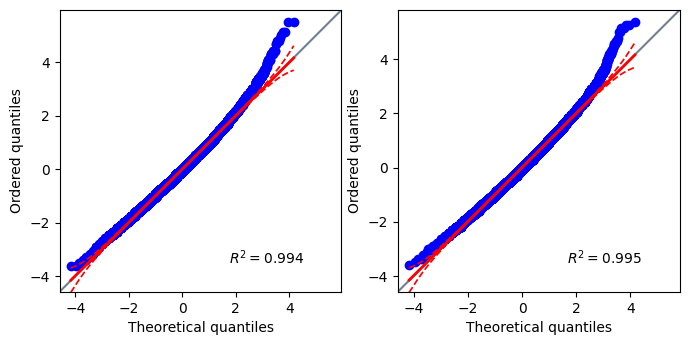

Defensive rebounds


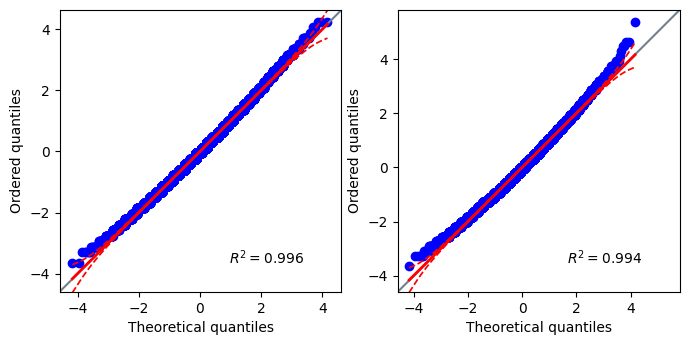

Assists


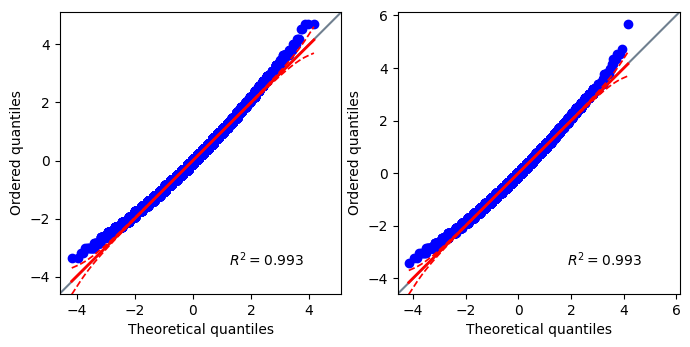

3 pointers attempted


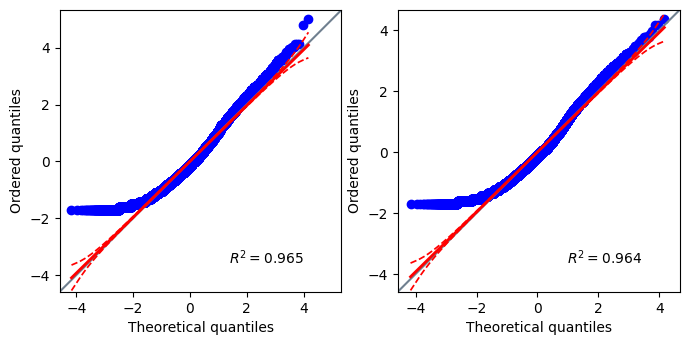

3 pointers made


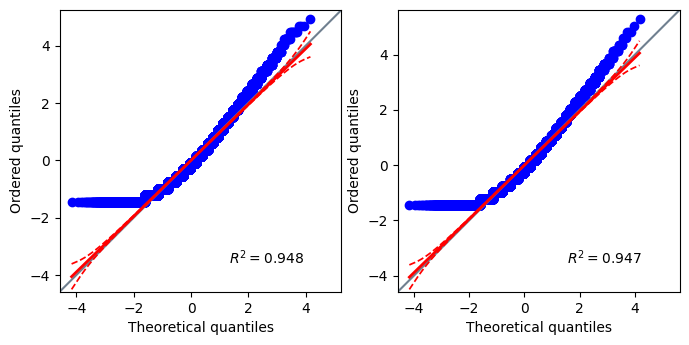

Blocks


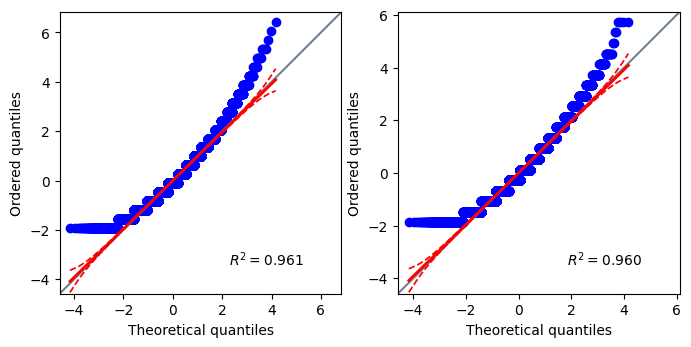

In [97]:
import pingouin as pg

good_dists = ['fga','dreb','ast']
bad_dists = ['fg3a','fg3m','blk']
translation = {'fga':'Field goals attempted','dreb':'Defensive rebounds','ast':'Assists','fg3a':'3 pointers attempted','fg3m':'3 pointers made','blk':'Blocks'}

def qq_plot_home_away(df,vars,translation):
    for var in vars:
        var_1 = var + '_home'
        var_2 = var + '_away'
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
        pg.qqplot(df[var_1], dist='norm', ax=axes[0])
        pg.qqplot(df[var_2], dist='norm', ax=axes[1])
        print(translation[var])
        plt.show()

qq_plot_home_away(game_eda,good_dists, translation)
qq_plot_home_away(game_eda,bad_dists,translation)

    

At least the curves look similar for home and away teams. Hopefully, we will be able to engineer the features a bit so that they more closely resemble normal distributions.

## Section 2: Correlation study
Now that we have a basic idea of what the distributions look like, we will focus on correlation coefficients. We will then focus on correlation with respect to the `'home_wins'`.

In [98]:
pearson_corr = game_eda.corr(method='pearson')
spearman_corr = game_eda.corr(method='spearman')
spearman_corr.head()


,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,Year,home_wins
fgm_home,1.000000,0.543756,0.097682,-0.018774,-0.113709,-0.127015,0.058084,0.136949,0.148588,0.675646,...,-0.220755,-0.127948,0.202798,-0.024158,-0.088183,0.054926,-0.115932,0.397451,-0.053783,0.331037
fga_home,0.543756,1.000000,0.071529,0.133054,-0.190418,-0.200847,0.463937,0.167782,0.443100,0.283851,...,0.379867,0.326367,0.231791,-0.109458,0.234508,0.110649,-0.164399,0.404008,0.034092,-0.047646
fg3m_home,0.097682,0.071529,1.000000,0.888914,-0.227854,-0.260237,-0.288166,0.199530,-0.019317,0.098312,...,0.201478,0.035425,0.022770,-0.068935,-0.071495,-0.149739,-0.265916,0.159045,0.713574,0.063330
fg3a_home,-0.018774,0.133054,0.888914,1.000000,-0.239141,-0.269563,-0.243460,0.220028,0.027796,-0.032710,...,0.348148,0.132437,0.032548,-0.076903,-0.053302,-0.147015,-0.273473,0.170619,0.805875,-0.070604
ftm_home,-0.113709,-0.190418,-0.227854,-0.239141,1.000000,0.927780,0.097029,-0.000727,0.058950,-0.069203,...,-0.169057,-0.073577,0.069950,0.018580,-0.003328,0.091497,0.749388,0.175188,-0.223335,0.187299


We will look at the thresholds at which the correlation changes in order to select a reasonable threshold. We will work with the Spearman correlation.

(33, 33)


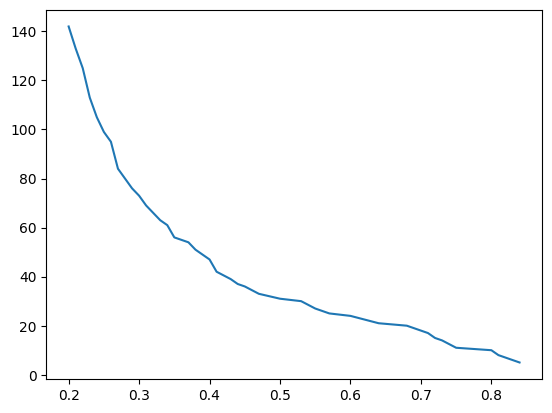

In [99]:
from src.utils import count_threshold_changes

print(spearman_corr.shape)
thresholds = [i/100 for i in range(20,85)]
changes = count_threshold_changes(spearman_corr, thresholds)
sns.lineplot(x=[change[0] for change in changes], y=[change[1]/2 for change in changes])
plt.show()


There are approximately 20 unique pairs of features that have correlation coefficient at least 0.7. Let us see what some of these pairs are and look at the associated scatter plots. Some of these variables should be strongly correlated, like shots attempted and shots made, for various different shots.

20


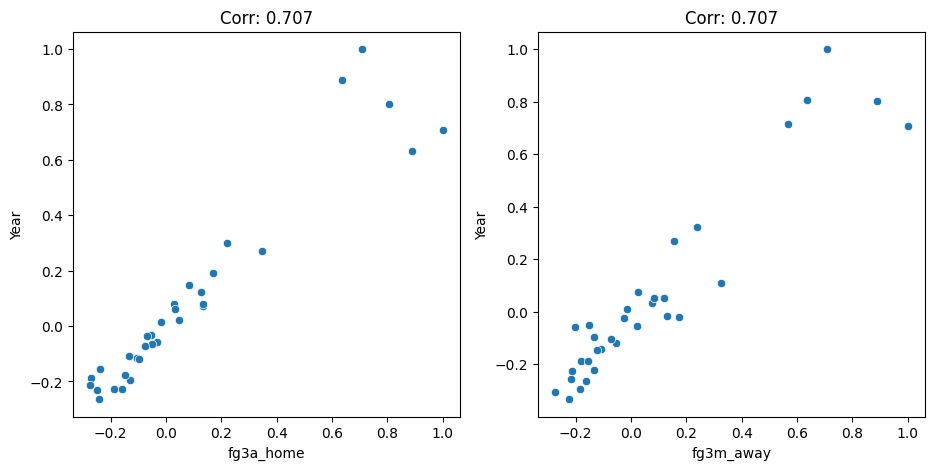

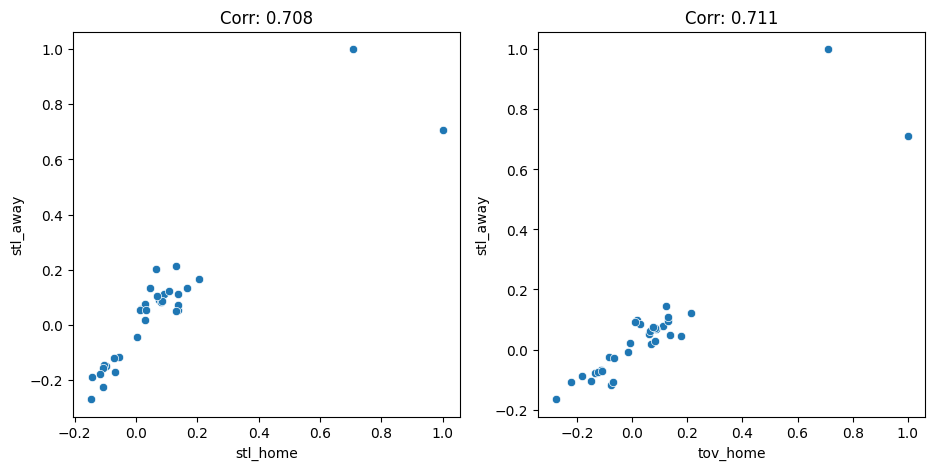

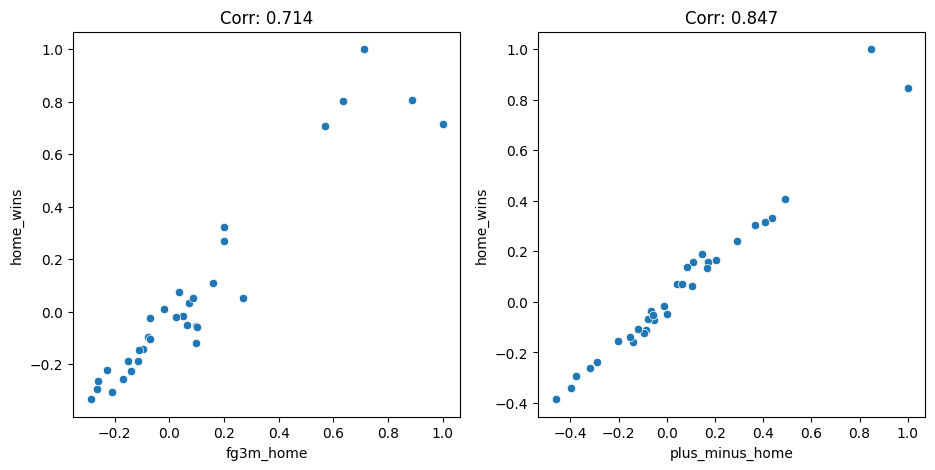

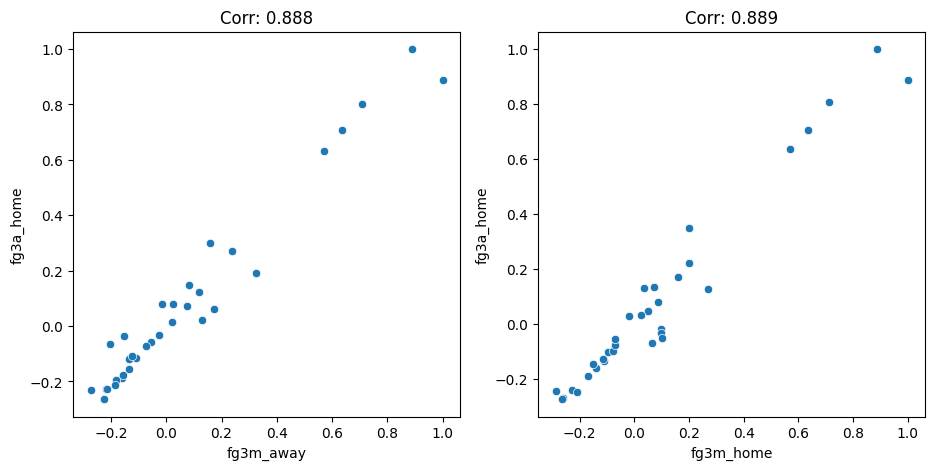

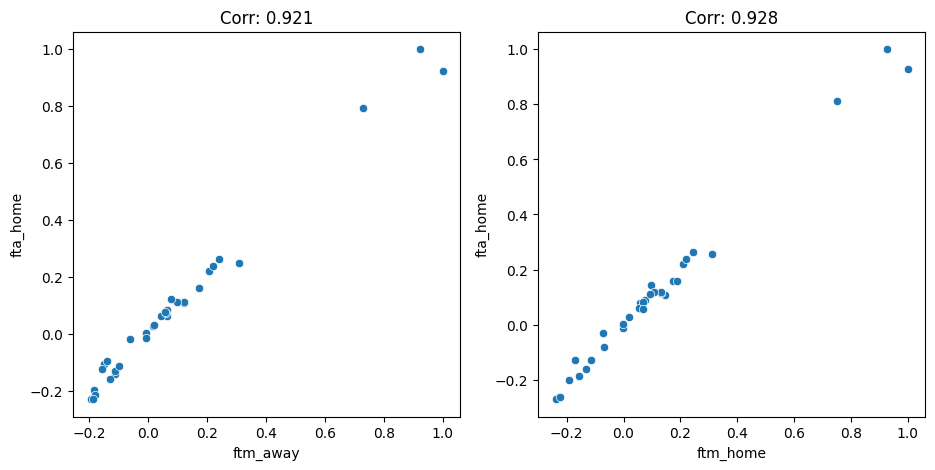

In [100]:
from src.utils import get_pairs

pairs = get_pairs(spearman_corr,0.7)
print(len(pairs))

parts = pairs[:5]+pairs[-5:]
for index in range(len(parts)//2):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11, 5))
    sns.scatterplot(x=parts[2*index][0], y=parts[2*index][1], data=spearman_corr, ax=axes[0])
    axes[0].set_title(f"Corr: {parts[2*index][2]}")
    axes[0].set_ylabel(parts[2*index+1][1])
    axes[0].set_xlabel(parts[2*index][0])
    sns.scatterplot(x=parts[2*index+1][0], y=parts[2*index+1][1], data=spearman_corr, ax=axes[1])
    axes[1].set_title(f"Corr: {parts[2*index+1][2]}")
    axes[1].set_ylabel(parts[2*index+1][1])
    axes[1].set_xlabel(parts[2*index+1][0])
    plt.show()





We find it quite interesting that `'Year'` has such a strong correlation with 3 point shots, made and attempted. This isn't so surprising and we would wager that this is related to the impact Steph Curry has had on the game.

We will now focus on what correlates with the wins. Remember that this is recorded as when the home team wins, so statistics for the away team are functionally statistics for the opponent.

In [101]:
pearson_corr_wins = pearson_corr['home_wins'].sort_values(key=abs, ascending=False)[1:]
print(pearson_corr_wins[:11])
spearman_corr_wins = spearman_corr['home_wins'].sort_values(key=abs, ascending=False)[1:]
print(spearman_corr_wins[:11])


plus_minus_home    0.798495
pts_home           0.404435
pts_away          -0.386229
dreb_away         -0.343750
fgm_home           0.331596
ast_home           0.315810
dreb_home          0.307699
fgm_away          -0.299504
ast_away          -0.266257
reb_away          -0.241296
reb_home           0.239932
Name: home_wins, dtype: float64
plus_minus_home    0.846898
pts_home           0.407112
pts_away          -0.385031
dreb_away         -0.342127
fgm_home           0.331037
ast_home           0.314473
dreb_home          0.305353
fgm_away          -0.295041
ast_away          -0.260685
reb_away          -0.240049
reb_home           0.239287
Name: home_wins, dtype: float64


The `'plus_minus_home'` scores is the difference in points between the home team and the away team. Naturally this will correlate most strongly with winning. Similarly, `'pts'` will correlate quite strongly with winning since that is how the winner of the game is actually determined.

We will focus on the 6 next features with that have the strongest correlation with winning. Note that both Pearson and Spearman produce the same list of features.


In [102]:
vars_to_study = list(pearson_corr_wins[3:9].index)
vars_to_study.sort()
print(vars_to_study)

['ast_away', 'ast_home', 'dreb_away', 'dreb_home', 'fgm_away', 'fgm_home']



The following are the statistics with the least correlation with wins. It is slightly reassuring that the correlation is so weak, but it is a bit odd that it is more strongly correlated with winning than offensive rebounds.

In [103]:
pearson_corr_wins[-6:]

tov_home    -0.069394
fg3a_home   -0.066227
Year        -0.051915
fga_home    -0.049170
fg3a_away   -0.036388
oreb_home   -0.019643
Name: home_wins, dtype: float64

This tells an interesting story. Aside from points, the statistic with the highest correlation to wins is the defensive rebounds of the opposing team.

Lets look at the distribution of these statistics. We will color the histograms according two which team won. We will also look at box plots and qq plots.

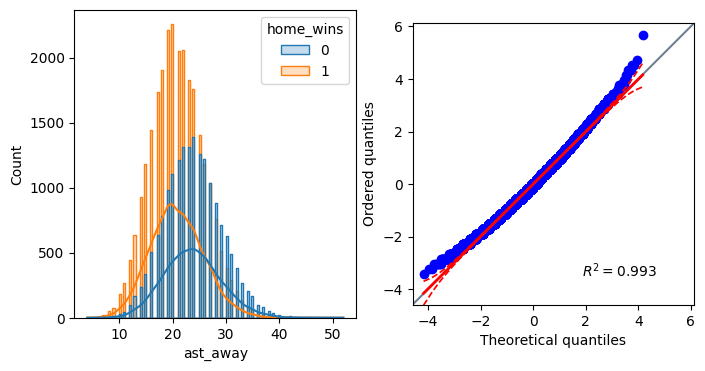

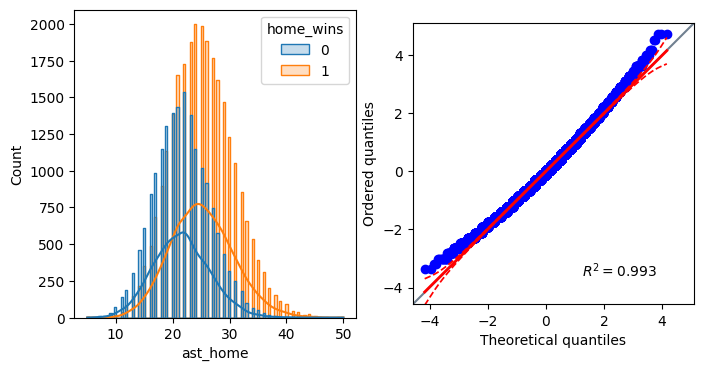

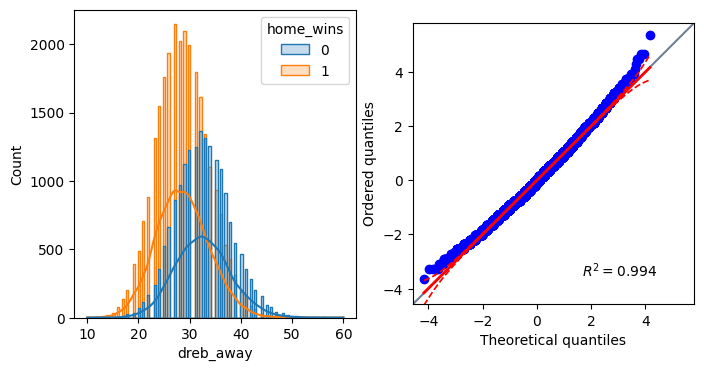

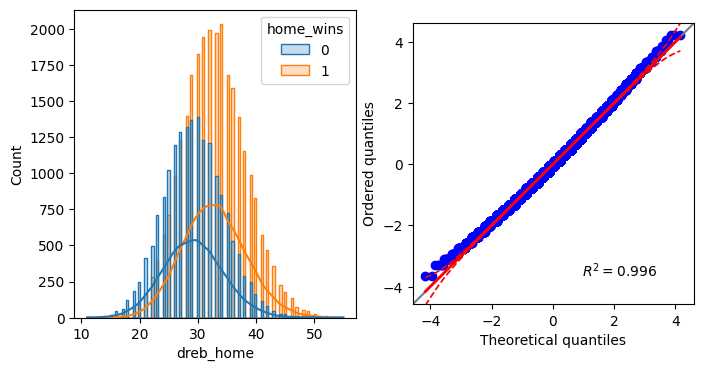

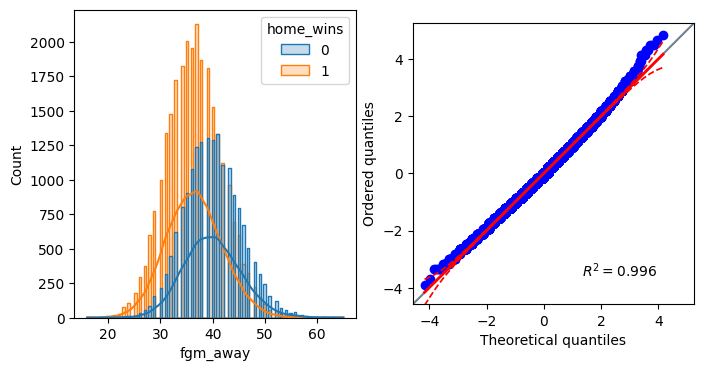

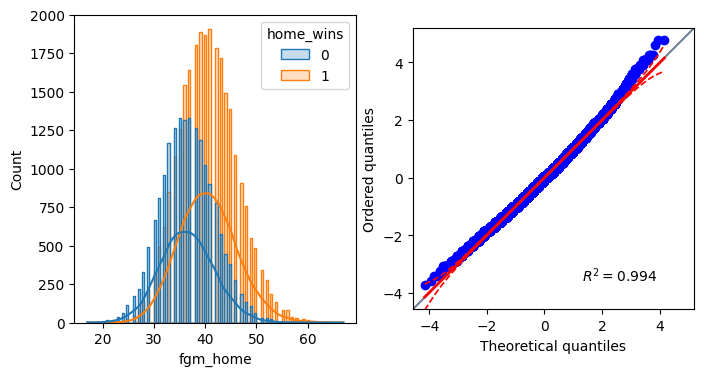

In [104]:
import pingouin as pg

for var in vars_to_study:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    sns.histplot(data=game_eda, x=var, hue='home_wins',kde=True, element="step", ax=axes[0])
    pg.qqplot(game_eda[var], dist='norm',ax=axes[1])
    plt.show()

# Attention
Explain the above graphs a bit more, perhaps before they appear.

Note the symmetry in these distributions. Swapping `'home'` to `'away'` is statistically equivalent to reflection across the y-axis. This is good. We would expect such symmetry. It is not necessarily present though as each game only appears once in our data. While these distributions appear normal, we know from the analysis above that they are not. We will attempt to transform them to bring the more in line in the next notebook.

## Section 2: Predictive Power Score
There is also Predictive Power Score. It is able to measure asymetric relationships.

In [105]:
import ppscore as pps

pps_raw = pps.matrix(df=game_eda)



In [106]:
pps_results = pps_raw.query('case != "predict_itself"').sort_values('ppscore', ascending=False)
pps_results = pps_results.filter(['x','y','ppscore'])
pps_results.head()

,x,y,ppscore
527,plus_minus_home,home_wins,1.000000
169,fta_home,ftm_home,0.634337
137,ftm_home,fta_home,0.634245
713,fta_away,ftm_away,0.620035
681,ftm_away,fta_away,0.618887


The score measures the ability of feature `x` to predict the value of feature `y`. It is unsurprising then that `'plus_minus_home'` is completely capable of predicting who wins.

In [114]:
pps_rounded = pps_results.query('ppscore!=0')
pps_rounded['ppscore'] = pps_rounded.apply(lambda x: round(x['ppscore'],4), axis=1)

print("mean: ",pps_rounded['ppscore'].mean())
print("mode: ",pps_rounded['ppscore'].mode())
print("median: ",pps_rounded['ppscore'].median())
print("standard deviation: ",pps_rounded['ppscore'].std())



mean:  0.06651673228346455
mode:  0    0.0023
Name: ppscore, dtype: float64
median:  0.020749999999999998
standard deviation:  0.12278902536083704


We are interested in predicting when the home team wins. So let's focus on that.

In [115]:
pps_wins = pps_results.query('y=="home_wins"')
pps_wins.sort_values('ppscore')
print(pps_wins.head())

                   x          y   ppscore
527  plus_minus_home  home_wins  1.000000
494         pts_home  home_wins  0.001652
758        oreb_away  home_wins  0.000000
791        dreb_away  home_wins  0.000000
890         stl_away  home_wins  0.000000


It seems that many of that values are able to predict one another. However, predicting wins seems much more difficult if we don't use the `'plus_minus_home'` value, which is 100% effective. Let's try and determine a reasonable threshold for the pp score.

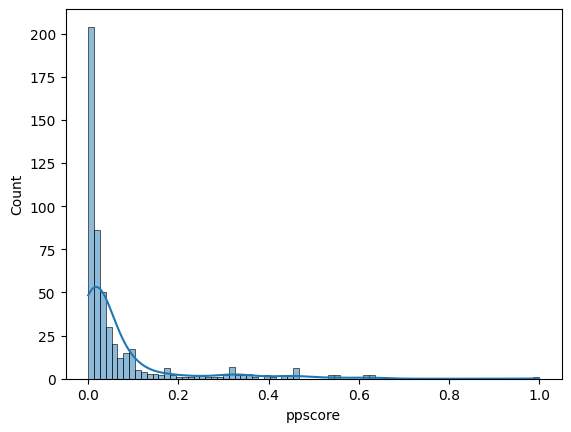

In [116]:
sns.histplot(data=pps_rounded, x='ppscore', kde=True)
plt.show()

If we look at the change in the number of rows as the threshold increases, it may help us determine an appropriate cut off.

The number of rows changes 45 times.


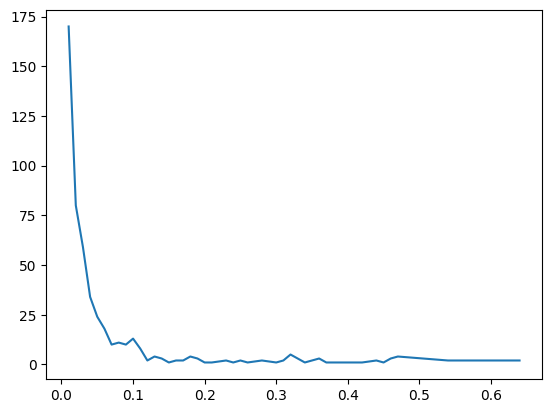

In [117]:
drop_off = count_threshold_changes(pps_rounded['ppscore'],[i/100 for i in range(100)],corr=False)
jumps = [(drop_off[index+1][0],-drop_off[index+1][1]+drop_off[index][1]) for index in range(len(drop_off)-1)]
print(f"The number of rows changes {len(jumps)} times.")
plt.plot([jump[0] for jump in jumps],[jump[1] for jump in jumps])
plt.show()

We will look at pps values larger than 0.3 and see what statistics show up.

(39, 3)
                   x          y  ppscore
527  plus_minus_home  home_wins   1.0000
169         fta_home   ftm_home   0.6343
137         ftm_home   fta_home   0.6342
713         fta_away   ftm_away   0.6200
681         ftm_away   fta_away   0.6189
              x          y  ppscore
1025       Year  fg3m_home   0.3149
97    fg3m_home       Year   0.3143
630   fg3a_away  fg3a_home   0.3118
118   fg3a_home  fg3a_away   0.3079
358    stl_home   tov_away   0.3077


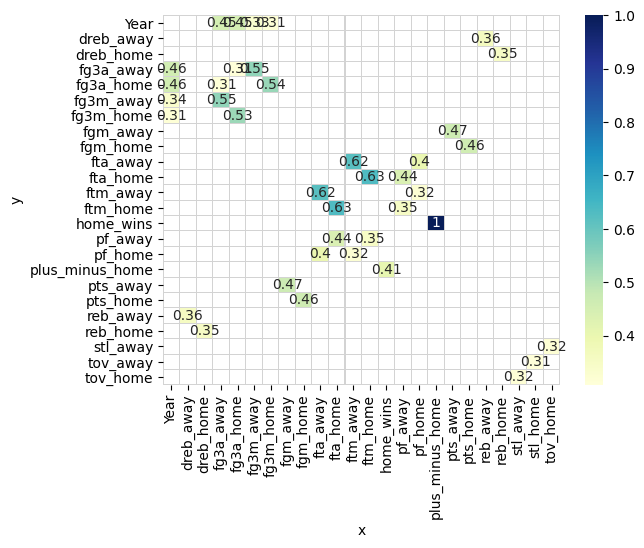

In [128]:
pps_truncated = pps_rounded.query('ppscore > 0.3')
print(pps_truncated.shape)
print(pps_truncated.head())
print(pps_truncated.iloc[-5:])
pps_table = pps_truncated.pivot(columns='x', index='y', values='ppscore')
sns.heatmap(pps_table, annot=True, cmap="YlGnBu", linewidth=0.05,linecolor='lightgrey', xticklabels=True, yticklabels=True)
plt.show()

Above, we see a lot of obvious relationships. Relationships between plus/minus score vs wins, attempted shots vs made shots, and personal fouls vs free throws. One interesting relationship is that between year and 3-point attempts, we also saw this in the correlation study. It is also interesting how little predictive power some statistics have on each other, such as field goals made and field goals attempted. There is also a surprising amount of symmetry in the statistics.

Let's consider the predictive power of the features we highlighted in the correlation study.

In [122]:
print(vars_to_study)
pps_home_wins = pps_results[pps_results['x'].isin(vars_to_study)].query('y=="home_wins"')
pps_home_wins

['ast_away', 'ast_home', 'dreb_away', 'dreb_home', 'fgm_away', 'fgm_home']


,x,y,ppscore
791,dreb_away,home_wins,0.0
857,ast_away,home_wins,0.0
329,ast_home,home_wins,0.0
263,dreb_home,home_wins,0.0
32,fgm_home,home_wins,0.0
560,fgm_away,home_wins,0.0


None of these statistics that have a strong correlation seem to have predictive power. Thus, we don't feel there is a lot of insight to be gained from the `'ppscore'`. Perhaps this is because it is easy to imagine how these statistics influence each other.

---

## Next Steps

In the next notebook, we will do some feature engineering. In the previous notebook we truncated the data so that we have no missing values. This means we won't have much cleaning to do. We will spend a lot of our time seeing if we can transform our features so that they are closer to normal distributions.

## Conclusions

Both correlation and pps values confirm common sense related to Basketball, attempts correlates with successes. One standout is the relationship between year and 3 point shots (both made and attempted). We have highlighted some statistics:
* Assists (home and away teams)
* Defensive Rebounds (home and away teams)
* Field Goals Made (home and away teams)

In particular, the correlation of the opposing teams number of defensive rebounds had a comparatively strong correlation with winning.